Train-accuracy: 0.8782 Test-accuracy: 0.8331
Drift, No. of iterations: 4
Drift, No. of iterations: 7
Drift, No. of iterations: 11
Drift, No. of iterations: 16
Drift, No. of iterations: 20
Drift, No. of iterations: 22
Drift, No. of iterations: 27
Drift, No. of iterations: 31
Drift, No. of iterations: 35
Drift, No. of iterations: 41
Drift, No. of iterations: 43
Drift, No. of iterations: 45
Drift, No. of iterations: 49
 
 ### TOTAL AMOUNT OF DRIFTS:  13 ###


<IPython.core.display.Javascript object>


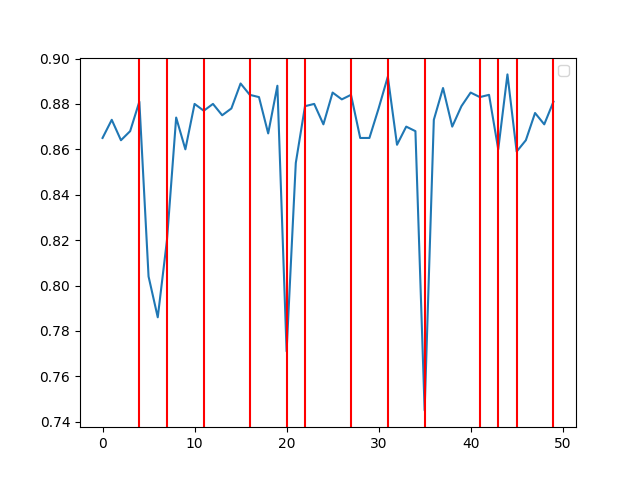

No handles with labels found to put in legend.


Accuracy: 0.8662400000000001


In [1]:
%matplotlib notebook
import pandas as pd
from skmultiflow.data.data_stream import DataStream
from sklearn import svm
from sklearn.metrics import accuracy_score

df = pd.read_csv('data/sea.csv')
features = df.iloc[:, 0:3]
target = df.iloc[:, -1:]
df.head()

# Create a stream with the data 
stream = DataStream(data = df)
stream.prepare_for_use()

# Create a Support Vector Machine with gamma=0.01
clf = svm.SVC(gamma=0.01)

# get the first 10000 samples of the stream 
X_train, y_train = stream.next_sample(10000)

# Train your SVM classifier with these samples
trained_model = clf.fit(X_train, y_train)

# Get amount of remaining samples & use them as testing data
X_test, y_test = stream.next_sample(stream.n_remaining_samples())

print("Train-accuracy:" , accuracy_score(y_train, trained_model.predict(X_train)), 
      "Test-accuracy:" , accuracy_score(y_test, trained_model.predict(X_test)))

from skmultiflow.drift_detection import PageHinkley

def compute_ph_statistics(mean_score, ph_sum, score, ph_sum_list, sample_count):
    # Compute new mean
    mean_new = mean_score + ((score - mean_score) / sample_count)
    
    # Compute new sum of deviations
    ph_sum_new = ph_sum + (score - mean_new)
    ph_sum_list.append(ph_sum_new)
    
    # Compute change statistics
    statistic_max = max(ph_sum_list) - ph_sum_new
    statistic_min = ph_sum_new - min(ph_sum_list)

    return (mean_new, ph_sum_new, ph_sum_list, statistic_max, statistic_min)

def reset_values():
    ph_mean = 0
    ph_sum = 0
    ph_sum_list = []
    sample_count = 1
    return(ph_mean, ph_sum, ph_sum_list, sample_count)

import matplotlib.pyplot as plt
import numpy as np

stream.restart()
clf = svm.SVC(gamma=0.01)

# Set initial values
sample_count = 1
ph_mean = 0
ph_sum = 0

# Threshold for change detection
ph_lambda = 0.01

ph_sum_list = []
ph_score_list = []
drift_detected = []

# Use 10000 data instances for the first model training
X_train, y_train = stream.next_sample(10000)
clf.fit(X_train, y_train)

for i in range(int(stream.n_remaining_samples()/1000)):
    X_test, y_test = stream.next_sample(1000)
    score = clf.score(X_test, y_test)
    ph_score_list.append(score)
    
    ph_mean, ph_sum, ph_sum_list, statistic_max, statistic_min = compute_ph_statistics(ph_mean, ph_sum, score, ph_sum_list, sample_count)
    sample_count += 1

    if ((statistic_max > ph_lambda) | (statistic_min > ph_lambda)):
        ph_mean, ph_sum, ph_sum_list, sample_count = reset_values()
        print('Drift, No. of iterations:', i)
        
        # Save drift point for later plotting
        drift_detected.append(i)
        clf.fit(X_test, y_test)
        
print(" \n ### TOTAL AMOUNT OF DRIFTS: " , len(drift_detected) , "###")

# Plots the score list
plt.figure()
plt.plot(ph_score_list)

for i in drift_detected:
    plt.axvline(i, color = 'red')
    
plt.legend()
plt.show()
print('Accuracy:', np.mean(ph_score_list))

##### PERFORMANCE WITH GRID SEARCH PARAMETERS #####
Accuracy:  0.8662   Amount of drifts:  13   Lambda:  0.01   Gamma:  0.01
Accuracy:  0.8713   Amount of drifts:  14   Lambda:  0.01   Gamma:  0.1
Accuracy:  0.8597   Amount of drifts:  13   Lambda:  0.01   Gamma:  1
Accuracy:  0.6726   Amount of drifts:  17   Lambda:  0.01   Gamma:  10
Accuracy:  0.866   Amount of drifts:  3   Lambda:  0.05   Gamma:  0.01
Accuracy:  0.8738   Amount of drifts:  3   Lambda:  0.05   Gamma:  0.1
Accuracy:  0.8612   Amount of drifts:  3   Lambda:  0.05   Gamma:  1
Accuracy:  0.6855   Amount of drifts:  7   Lambda:  0.05   Gamma:  10
Accuracy:  0.8685   Amount of drifts:  3   Lambda:  0.1   Gamma:  0.01
Accuracy:  0.8714   Amount of drifts:  3   Lambda:  0.1   Gamma:  0.1
Accuracy:  0.8617   Amount of drifts:  3   Lambda:  0.1   Gamma:  1
Accuracy:  0.692   Amount of drifts:  3   Lambda:  0.1   Gamma:  10
Accuracy:  0.8331   Amount of drifts:  0   Lambda:  1   Gamma:  0.01
Accuracy:  0.8393   Amount of drift

<IPython.core.display.Javascript object>


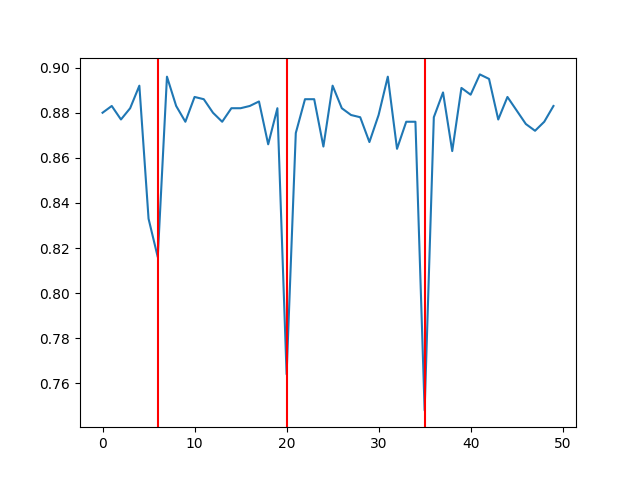

In [2]:
from sklearn.model_selection import GridSearchCV

parameters = {'lambda':[0.01, 0.05, 0.1, 1], 'gamma':[0.01, 0.1, 1, 10]}

def grid_search(grid_lambda, grid_gamma):
    stream.restart()
    clf = svm.SVC(gamma=grid_gamma)

    # Set initial values
    sample_count = 1
    ph_mean = 0
    ph_sum = 0

    # Threshold for change detection
    ph_lambda = grid_lambda

    ph_sum_list = []
    ph_score_list = []
    drift_detected = []

    X_train, y_train = stream.next_sample(10000)
    clf.fit(X_train, y_train)
    for i in range(int(stream.n_remaining_samples()/1000)):
        X_test, y_test = stream.next_sample(1000)
        score = clf.score(X_test, y_test)
        ph_score_list.append(score)
    
        ph_mean, ph_sum, ph_sum_list, statistic_max, statistic_min = compute_ph_statistics(ph_mean, ph_sum, score, ph_sum_list, sample_count)
        sample_count += 1

        if ((statistic_max > ph_lambda) | (statistic_min > ph_lambda)):
            ph_mean, ph_sum, ph_sum_list, sample_count = reset_values()
        
            # Save drift point for later plotting
            drift_detected.append(i)
            clf.fit(X_test, y_test)
            
    return drift_detected, ph_score_list

accuracy_best = 0
drifts_amount_best = 0
lambda_best = 0
gamma_best = 0
amount_drifts_values = 0
score_list_best = []
    
    
print("##### PERFORMANCE WITH GRID SEARCH PARAMETERS #####")
#manually use grid search
for l in parameters["lambda"]:
    for g in parameters ["gamma"]:
        drift_detected, score_list = grid_search(l, g)
        accuracy = np.mean(score_list)
        print("Accuracy: " , round(accuracy,4) , "  Amount of drifts: " , len(drift_detected) , 
              "  Lambda: " , l , "  Gamma: " , g)
        
        #here best result only depends on accuracy
        if accuracy_best < accuracy:
            #Save best result  in specific variables
            accuracy_best, drifts_amount_best, lambda_best, gamma_best, score_list_best, amount_drifts_values  = accuracy, len(drift_detected), l, g, score_list, drift_detected 
print("#"*51)            
print("\n"*2,
    "##### THE BEST PARAMETERS - measured by accuracy score ##### \n" , 
      "ACCURACY: " , round(accuracy_best,4), 
      "Amount of drifts: " , drifts_amount_best,
      "Lambda: " , lambda_best ,
      "Gamma: " , gamma_best, "\n",
      "#"*60)

plt.subplots()
plt.plot(score_list_best)
for i in amount_drifts_values:
    plt.axvline(i, color = 'red') 
plt.show()